__Imports__

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot

__Dataset__

In [2]:
digits = tf.keras.datasets.mnist.load_data(path='mnist.npz')
(x_train_full,y_train_full),(x_test,y_test) = digits

In [3]:
x_train_full.shape

(60000, 28, 28)

In [4]:
x_valid,x_train = x_train_full[:5000]/255.,x_train_full[5000:]/255.
y_valid,y_train = y_train_full[:5000],y_train_full[5000:]
x_test = x_test / 255.

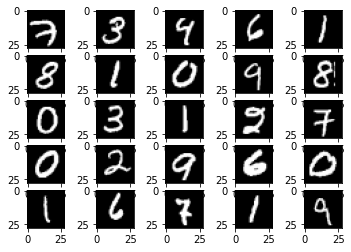

In [5]:
for i in range(25):
# define subplot
    pyplot.subplot(5, 5, i+1)
    # plot raw pixel data
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

__Clear the Backend__

In [6]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

__Piecewise Constant Scheduling__
* Added an additional learning constant
* A dynamic learning process

In [7]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 10:
        return 0.005
    elif epoch < 15:
        return 0.003
    elif epoch < 20:
        return 0.001
    else:
        return 0.0001

In [8]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn
piecewise_constant_fn = piecewise_constant([5,10,15,20,25], [0.01, 0.005,0.003,0.001,0.0001])

In [9]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

__Model Creation__

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3),padding="valid" ,
                              activation='selu',kernel_initializer="lecun_normal", input_shape=(28,28,1)))
model.add(keras.layers.AveragePooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3),padding="valid", 
                              activation='selu',kernel_initializer="lecun_normal"))
model.add(keras.layers.AveragePooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.GaussianDropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=120, activation='selu',kernel_initializer="lecun_normal"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=84, activation='selu',kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(units=10, activation = 'softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 13, 13, 6)        0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 6)        24        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                        

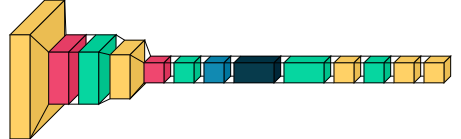

In [12]:
import visualkeras
visualkeras.layered_view(model)

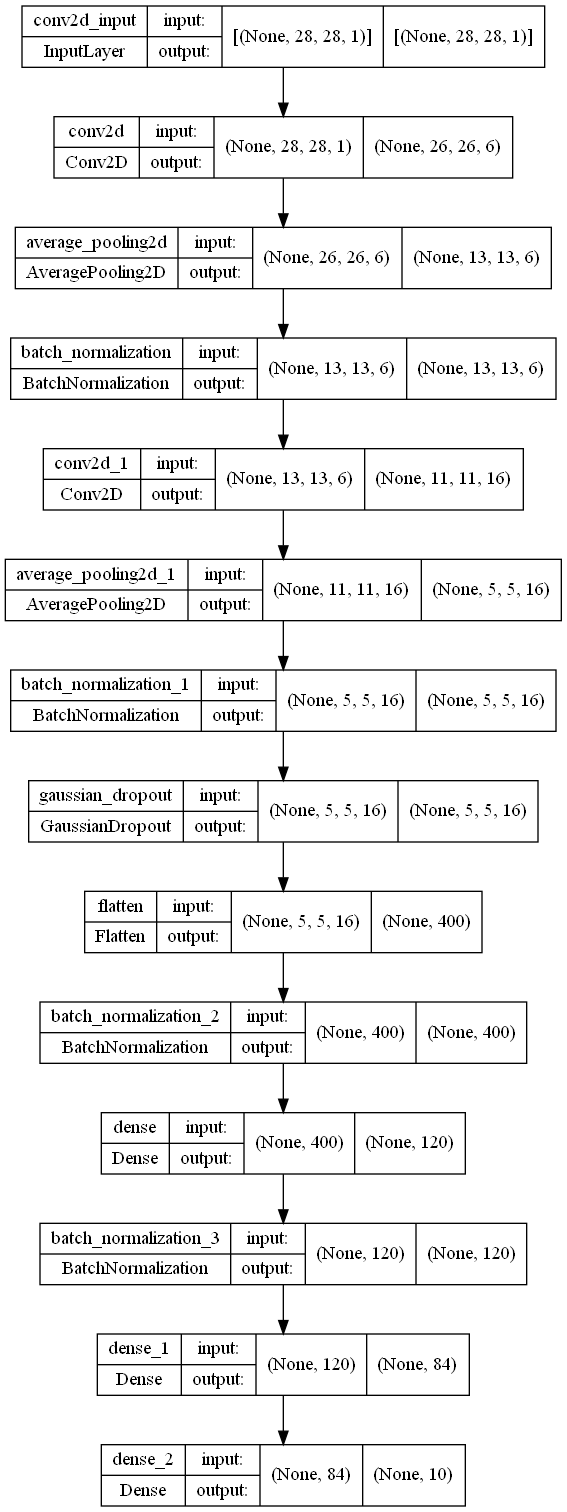

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'model.png', show_shapes=True)

__Model Compile__

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(clipvalue=1.0,clipnorm=1.0),metrics=["accuracy"])

__Model Fitting__

In [15]:
history = model.fit(x_train,y_train,epochs=25,validation_data=(x_valid,y_valid),callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 16s 5ms/step - loss: 0.2463 - accuracy: 0.9275 - val_loss: 0.1264 - val_accuracy: 0.9648 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1408 - accuracy: 0.9593 - val_loss: 0.0887 - val_accuracy: 0.9802 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1248 - accuracy: 0.9646 - val_loss: 0.0870 - val_accuracy: 0.9758 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1214 - accuracy: 0.9652 - val_loss: 0.0651 - val_accuracy: 0.9846 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1128 - accuracy: 0.9686 - val_loss: 0.0859 - val_accuracy: 0.9766 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0659 - accuracy: 0.9799 - val_loss: 0.0447 - val_accuracy: 0.9894 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 8

In [16]:
mse_test = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0221 - accuracy: 0.9933


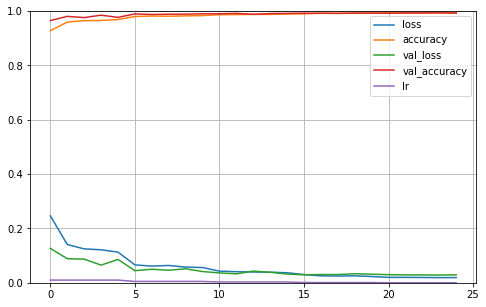

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

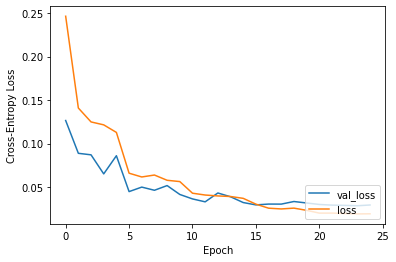

In [22]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='lower right')

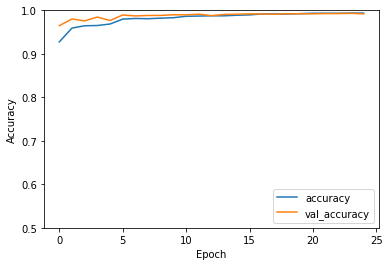

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [20]:
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
y_pred = [np.argmax(i) for i in y_pred]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [21]:
import sklearn.metrics as sk
hl = sk.hamming_loss(y_test, y_pred)
js = sk.jaccard_score(y_test, y_pred,average=None)
bss = sk.balanced_accuracy_score(y_test,y_pred)
mcc = sk.matthews_corrcoef(y_test,y_pred)
print("Hamming Loss: "+ str(hl))
print("Jaccard index \n"+ "0\t" + str(js[0]) +"\n" +  "1\t" + str(js[1]) + "\n" + "2\t" + str(js[2])+"\n" + "3\t" + str(js[2]) + 
     "\n"+"4\t"+str(js[3]) + "\n"+"5\t"+str(js[4]) +"\n"+"6\t"+str(js[5]) + "\n"+"7\t"+str(js[6]) + "\n"+"8\t"+str(js[7])
     + "\n"+"9\t"+str(js[8]))
print("Balanced Accuracy Score: " + str(bss))
print("Matthews Correlation Coefficient: "+ str(mcc))

Hamming Loss: 0.0067
Jaccard index 
0	0.9898682877406282
1	0.9912510936132983
2	0.9922779922779923
3	0.9922779922779923
4	0.9882237487733072
5	0.9848024316109423
6	0.9843924191750278
7	0.983402489626556
8	0.9845857418111753
9	0.9897645854657113
Balanced Accuracy Score: 0.9931711518302743
Matthews Correlation Coefficient: 0.9925535439751005
